In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataloader
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display
import torch.optim as optim

import h5py
import sys
sys.path.append('../')
from utils.common_fcns import *
import matplotlib
from matplotlib import pyplot as plt

/home/alex/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda')

### Load Data

In [3]:
# Uncomment the below line if you haven't created the dataset file yet
#!python prepare_training_data.py 

# Load in the data file
df = pd.read_pickle('../data/training_set.pkl')
display(df)

class Data(Dataset):
    def __init__(self, x, y):
        super(Data, self).__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

train_slices = df['slice'].to_numpy()
data = Data(train_slices,train_slices)

,slice_name,slice
0,file_brain_AXT2_200_2000535_0,"[0.0029112822, 0.0022742343, 0.0024876709, 0.0..."
1,file_brain_AXT2_200_2000535_1,"[0.00254231, 0.0018121544, 0.0022545222, 0.002..."
2,file_brain_AXT2_200_2000535_2,"[0.0021948142, 0.001427773, 0.0019365047, 0.00..."
3,file_brain_AXT2_200_2000535_3,"[0.0019062636, 0.0010817663, 0.0016660133, 0.0..."
4,file_brain_AXT2_200_2000535_4,"[0.001538842, 0.00081564067, 0.0013866577, 0.0..."
...,...,...
425,file_brain_AXT2_200_2000368_11,"[5.3744112e-05, 5.3206768e-05, 5.620142e-05, 5..."
426,file_brain_AXT2_200_2000368_12,"[5.141851e-05, 5.086812e-05, 5.1086612e-05, 5...."
427,file_brain_AXT2_200_2000368_13,"[5.5321667e-05, 5.2995976e-05, 5.153848e-05, 5..."
428,file_brain_AXT2_200_2000368_14,"[5.176266e-05, 5.110678e-05, 5.0593735e-05, 5...."


### Define the Neural Network

In [4]:
# Inherit from torch.nn, define basic k-latent AutoEncoder
k_latent = 3000

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.k_latent_encode = nn.Linear(256*256, k_latent)
        self.k_latent_decode = nn.Linear(k_latent, 256*256)

    def forward(self, x):
        x = self.k_latent_encode(x)
        x = torch.relu(x)
        x = self.k_latent_decode(x)
        x = torch.sigmoid(x)
        return x

### Train the Model

In [5]:
# Training setup
n_epochs = 250
minibatch_size = 429 #Full batch
batch_loss = np.zeros(n_epochs)

model = AutoEncoder()
#model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1000)
criterion = nn.MSELoss()

In [6]:
# Do training
for epoch in range(n_epochs):
    # Pick batches for this epoch
    train_loader = torch.utils.data.DataLoader(data, batch_size=minibatch_size, shuffle=True)
    for batch_idx, (X, _) in enumerate(train_loader):
        optimizer.zero_grad()   # zero the gradient buffers
        Y = model(X)
        loss = criterion(X,Y)
        batch_loss[epoch]+=loss.item() # save off the loss
        loss.backward()
        optimizer.step()    # update
    print("Completed epoch: "+str(epoch)+" , Loss: "+str(batch_loss[epoch]))

Completed epoch: 0 , Loss: 1.6307484209537506
Completed epoch: 1 , Loss: 0.10318797663785517
Completed epoch: 2 , Loss: 0.008269662677776068
Completed epoch: 3 , Loss: 0.004323765751905739
Completed epoch: 4 , Loss: 0.0028739675180986524
Completed epoch: 5 , Loss: 0.0021294427278917283
Completed epoch: 6 , Loss: 0.0016798835276858881
Completed epoch: 7 , Loss: 0.0013807199138682336
Completed epoch: 8 , Loss: 0.0011680585594149306
Completed epoch: 9 , Loss: 0.0010096378246089444
Completed epoch: 10 , Loss: 0.0008873365077306516
Completed epoch: 11 , Loss: 0.0007902452416601591
Completed epoch: 12 , Loss: 0.0007114072868716903
Completed epoch: 13 , Loss: 0.0006461790326284245
Completed epoch: 14 , Loss: 0.0005913760687690228
Completed epoch: 15 , Loss: 0.0005447449366329238
Completed epoch: 16 , Loss: 0.0005046119840699248
Completed epoch: 17 , Loss: 0.00046970631956355646
Completed epoch: 18 , Loss: 0.0004391111942823045
Completed epoch: 19 , Loss: 0.00041205002344213426
Completed epoch

### Test It

In [7]:
# Load a scan in
data_dir = '../data/multicoil_test/'
file = data_dir+'file_brain_AXT2_200_2000482.h5'
hf = h5py.File(file)
volume_kspace = hf['kspace'][()]
n_slices = volume_kspace.shape[0]
X_raw = combine_all_coils(volume_kspace,8)
X = resize_scan(X_raw)
X_encode = k_encode(10000,X)

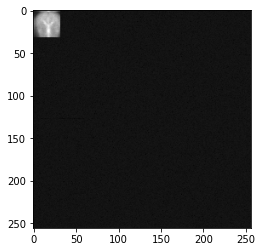

In [10]:
# Put it through our autoencoder and see what we get!
X_input = torch.from_numpy(X_encode.flatten())
X_output = model(X_input)
X_output = X_output.detach().numpy().reshape(256,256)
X_reconstruct = decode(X_output)
plt.imshow(np.abs(X_output), cmap='gray')